In [67]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

%matplotlib inline

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')



import pathlib

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


In [68]:
# load the provided data
train_features = pd.read_csv('data-processed/dengue_features_train.csv',
                             index_col=[0,1,2])

train_labels = pd.read_csv('data-processed/dengue_labels_train.csv',
                           index_col=[0,1,2])


In [70]:
train_features.isna().sum()

week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_precip_mm                         22
dtype: int64

In [71]:
train_labels.isna().sum()

total_cases    0
dtype: int64

In [36]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']



In [72]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [73]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)



KeyError: "['week_start_date'] not found in axis"

NameError: name 'train_dataset' is not defined

In [41]:
# Null check
pd.isnull(sj_train_features).any()



ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_air_temp_k                    True
reanalysis_avg_temp_k                    True
reanalysis_dew_point_temp_k              True
reanalysis_max_air_temp_k                True
reanalysis_min_air_temp_k                True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_sat_precip_amt_mm             True
reanalysis_specific_humidity_g_per_kg    True
reanalysis_tdtr_k                        True
station_avg_temp_c                       True
station_diur_temp_rng_c                  True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
dtype: bool

Text(0.5, 0, 'Time')

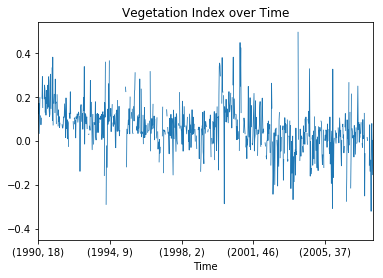

In [42]:
(sj_train_features.ndvi_ne.plot.line(lw=0.8))
plt.title('Vegetation Index over Time')
plt.xlabel('Time')



In [43]:

sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

In [44]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.18055555555556
var : 2640.0454396910277

Iquitos
mean:  7.565384615384615
var : 115.89552393656439


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67111f1c88>]],
      dtype=object)

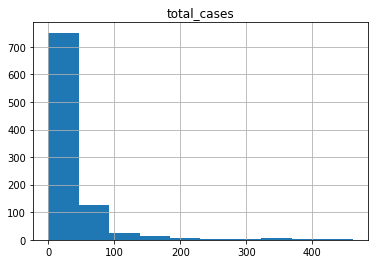

In [45]:

sj_train_labels.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67116472e8>]],
      dtype=object)

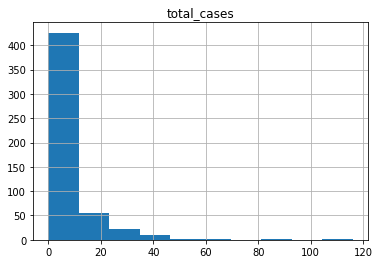

In [46]:
iq_train_labels.hist()

In [47]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

In [48]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

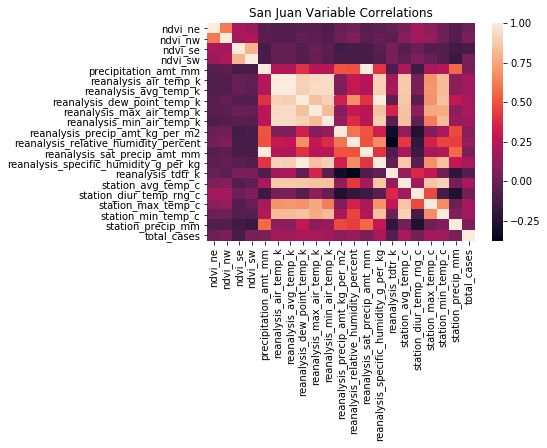

In [49]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

Text(0.5, 1.0, 'Iquitos Variable Correlations')

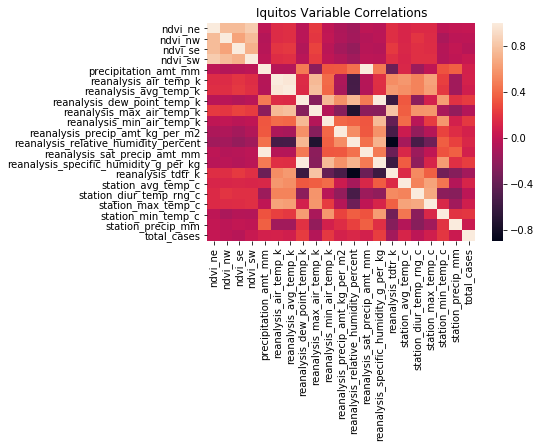

In [50]:

# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title('Iquitos Variable Correlations')

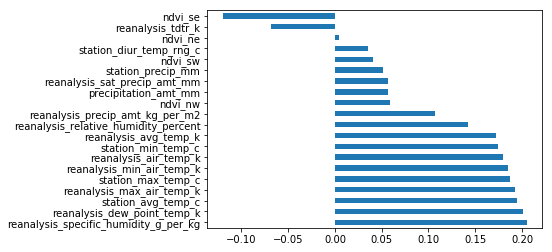

In [51]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

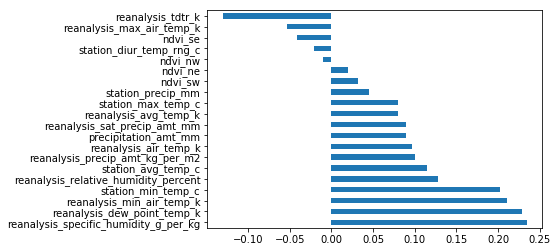

In [52]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

In [53]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['ndvi_sw', 
                 'reanalysis_dew_point_temp_k', 
                 'station_precip_mm', 
                 'reanalysis_min_air_temp_k',
               'ndvi_ne',
               'reanalysis_tdtr_k',
               'reanalysis_precip_amt_kg_per_m2',
               'reanalysis_max_air_temp_k',
               'ndvi_nw',
               'station_max_temp_c']
    df = df[features]
    
    # fill missing values
    df.fillna(df.mean(), inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
    
    # separate san juan and iquitos
    sj_train = df.loc['sj']
    iq_train = df.loc['iq']
    
    if(labels_path!=None):
        sj_labels = labels.loc['sj']
        iq_labels = labels.loc['iq']
    
        return sj_train, iq_train,sj_labels,iq_labels
    else:
        return sj_train, iq_train


In [54]:
sj_train, iq_train,sj_labels,iq_labels= preprocess_data('data-processed/dengue_features_train.csv',labels_path="data-processed/dengue_labels_train.csv")

In [75]:
iq_train.describe()


,ndvi_sw,reanalysis_dew_point_temp_k,station_precip_mm,reanalysis_min_air_temp_k,ndvi_ne,reanalysis_tdtr_k,reanalysis_precip_amt_kg_per_m2,reanalysis_max_air_temp_k,ndvi_nw,station_max_temp_c
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,0.266407,295.491085,61.755234,292.888609,0.263168,9.173683,57.475572,307.054632,0.238158,33.962758
std,0.086234,1.411922,62.391797,1.675324,0.081656,2.467929,50.115658,2.395210,0.076968,1.331230
min,0.064183,290.088571,0.000000,286.900000,0.061729,3.714286,0.000000,300.000000,0.035860,30.100000
25%,0.202366,294.596429,18.000000,292.000000,0.199482,7.353571,24.212500,305.100000,0.179350,33.100000
50%,0.261600,295.831429,44.000000,293.100000,0.263342,8.942857,45.985000,307.000000,0.232498,33.900000
75%,0.324877,296.544643,83.350000,294.200000,0.319618,11.003571,70.432500,308.700000,0.293832,34.800000
max,0.546017,298.450000,543.300000,296.000000,0.508357,16.028571,362.030000,314.000000,0.454429,42.200000


,count,mean,std,min,25%,50%,75%,max
ndvi_sw,936.0,0.166694,0.055737,-0.063457,0.129925,0.167988,0.202333,0.381420
reanalysis_dew_point_temp_k,936.0,295.110396,1.564936,289.642857,293.853214,295.447143,296.415714,297.795714
station_precip_mm,936.0,26.865874,29.248713,0.000000,6.900000,17.950000,36.450000,305.900000
reanalysis_min_air_temp_k,936.0,297.291683,1.296717,292.600000,296.300000,297.500000,298.400000,299.900000
ndvi_ne,936.0,0.075141,0.101457,-0.406250,0.021225,0.085965,0.142294,0.493400
reanalysis_tdtr_k,936.0,2.531572,0.532578,1.357143,2.157143,2.457143,2.800000,4.903754
reanalysis_precip_amt_kg_per_m2,936.0,30.527512,35.521978,0.000000,10.900000,21.405000,37.695000,570.500000
reanalysis_max_air_temp_k,936.0,301.411819,1.265289,297.800000,300.400000,301.500000,302.400000,304.300000
ndvi_nw,936.0,0.070772,0.091114,-0.456100,0.020469,0.072233,0.128275,0.437100
station_max_temp_c,936.0,31.613370,1.713105,26.700000,30.600000,31.700000,32.800000,35.600000


In [65]:
from sklearn.model_selection import train_test_split

X_train_sj, X_test_sj, y_train_sj, y_test_sj = train_test_split(sj_train, sj_labels, test_size=0.2, random_state=123)

In [66]:
X_train_iq, X_test_iq, y_train_iq, y_test_iq = train_test_split(iq_train, iq_labels, test_size=0.2, random_state=123)

In [79]:
train_stats = X_train_sj.describe()
train_stats = train_stats.transpose()
train_stats



,count,mean,std,min,25%,50%,75%,max
ndvi_sw,748.0,0.166735,0.055839,-0.063457,0.129778,0.168486,0.202333,0.381420
reanalysis_dew_point_temp_k,748.0,295.093837,1.569315,289.642857,293.853214,295.442857,296.402143,297.598571
station_precip_mm,748.0,27.222333,30.067538,0.000000,6.900000,17.950000,36.875000,305.900000
reanalysis_min_air_temp_k,748.0,297.274969,1.299947,292.600000,296.300000,297.500000,298.300000,299.600000
ndvi_ne,748.0,0.075086,0.103484,-0.406250,0.019192,0.087683,0.142294,0.493400
reanalysis_tdtr_k,748.0,2.528993,0.527387,1.400000,2.157143,2.457143,2.800000,4.903754
reanalysis_precip_amt_kg_per_m2,748.0,30.530063,37.020077,0.000000,10.900000,20.700000,37.172500,570.500000
reanalysis_max_air_temp_k,748.0,301.404557,1.259210,297.800000,300.400000,301.500000,302.400000,304.300000
ndvi_nw,748.0,0.070579,0.091341,-0.309600,0.017625,0.071288,0.129195,0.437100
station_max_temp_c,748.0,31.593997,1.704530,26.700000,30.600000,31.700000,32.800000,35.600000


In [83]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(X_train_sj)
normed_test_data = norm(X_test_sj)

In [84]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(X_train_sj.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model



In [85]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [86]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [88]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.17460006],
       [ 0.11691498],
       [-0.01844433],
       [ 0.32026973],
       [ 0.48091835],
       [ 0.10863306],
       [ 0.73902154],
       [ 0.33752576],
       [ 0.58427393],
       [ 0.31049824]], dtype=float32)

In [91]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, y_train_sj,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [93]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,104.536278,7.453693,104.536278,3305.341081,42.007618,3305.341309,995
996,95.582266,7.070940,95.582275,3264.283232,41.595127,3264.283203,996
997,105.482763,7.379362,105.482758,3434.368984,42.587410,3434.368896,997
998,92.140549,6.757302,92.140556,3281.632008,41.836903,3281.632080,998
999,107.004482,7.317620,107.004478,3293.866162,41.959846,3293.865967,999


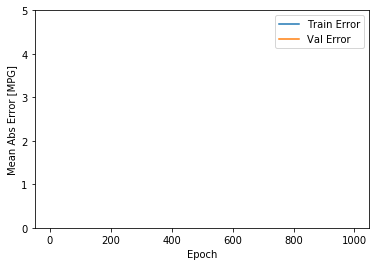

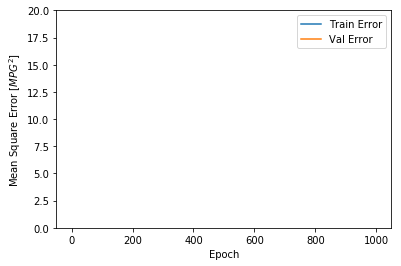

In [94]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


.................

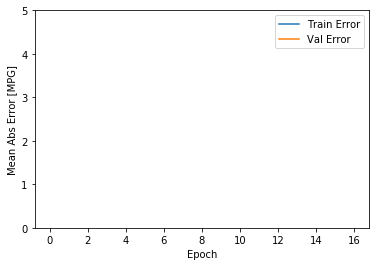

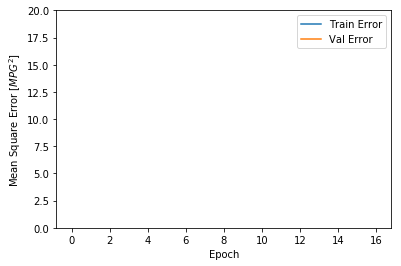

In [96]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, y_train_sj, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [97]:
loss, mae, mse = model.evaluate(normed_test_data, y_test_sj, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error: 28.71 MPG


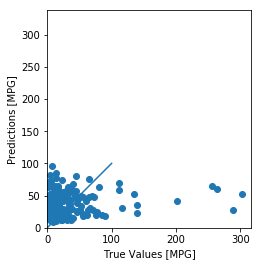

In [98]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(y_test_sj, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [100]:
error = test_predictions - y_test_sj
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

ValueError: Unable to coerce to Series, length must be 1: given 188

In [64]:
sj_test, iq_test = preprocess_data('data-processed/dengue_features_test.csv')

sj_predictions = sj_best_model_all.predict(sj_test).astype(int)
iq_predictions = iq_best_model_all.predict(iq_test).astype(int)

submission = pd.read_csv("data-processed/submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("data-processed/benchmark.csv")